<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed(sad%2Chap%2Cfear%2Cneu)GAN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Colab: LSTM with GAN for SEED Dataset (CSV Version)

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset from CSV
data_path = "/content/Corrected_Emotion_Labels.csv"
df = pd.read_csv(data_path)

# Assuming the last column is the label, and the rest are features
X = df.iloc[:, :-1].values  # EEG Features
Y = df.iloc[:, -1].values   # Emotion Labels

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Assuming each row is a time step

# Convert labels to categorical (Assuming 4 classes: Neutral, Happy, Sad, Fear)
Y = tf.keras.utils.to_categorical(Y, num_classes=4)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build LSTM Classifier
classifier = Sequential()
classifier.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
classifier.add(Dropout(0.2))
classifier.add(LSTM(32))
classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(4, activation='softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Train LSTM Classifier
classifier.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Define GAN Components
latent_dim = X.shape[2]

def build_generator():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=latent_dim))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(X.shape[2], activation='tanh'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[2],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    return model

generator = build_generator()
discriminator = build_discriminator()
discriminator.trainable = False

# Combined GAN Model
z = Input(shape=(latent_dim,))
gen_output = generator(z)
validity = discriminator(gen_output)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.001))

# Train GAN
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_samples = X_train[idx].reshape(batch_size, X.shape[2])
    fake_samples = generator.predict(np.random.normal(0, 1, (batch_size, latent_dim)))

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = gan.train_on_batch(np.random.normal(0, 1, (batch_size, latent_dim)), np.ones((batch_size, 1)))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D Loss={d_loss[0]}, G Loss={g_loss}")

# Evaluate LSTM after GAN Augmentation
accuracy = classifier.evaluate(X_test, Y_test)[1]
print(f"Final LSTM Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4288 - loss: 1.1732 - val_accuracy: 0.5431 - val_loss: 0.9727
Epoch 2/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5404 - loss: 0.9631 - val_accuracy: 0.5711 - val_loss: 0.9124
Epoch 3/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5594 - loss: 0.9194 - val_accuracy: 0.5835 - val_loss: 0.8793
Epoch 4/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5794 - loss: 0.8805 - val_accuracy: 0.5935 - val_loss: 0.8498
Epoch 5/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5906 - loss: 0.8521 - val_accuracy: 0.6112 - val_loss: 0.8213
Epoch 6/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6096 - loss: 0.8296 - val_accuracy: 0.6317 - val_loss: 0.7995
Epoch 7/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6285 - loss: 0.8016 - val_accuracy: 0.6541 - val_loss: 0.7628
Epoch 8/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6508 - loss: 0.7703 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss=0.7129952311515808, G Loss=0.6946858167648315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [1]:
# Install necessary libraries (if not installed)
!pip install tensorflow numpy pandas scikit-learn matplotlib

# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# Load dataset from CSV
data_path = "/content/Corrected_Emotion_Labels.csv"  # Change path if needed
df = pd.read_csv(data_path)

# Print first few rows
print(df.head())

# Assuming the last column is the label, and the rest are features
X = df.iloc[:, :-1].values  # EEG Features
Y = df.iloc[:, -1].values   # Emotion Labels

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Each row is treated as a single time step

# Convert labels to categorical (4 classes: Neutral, Happy, Sad, Fear)
Y = tf.keras.utils.to_categorical(Y, num_classes=4)

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print data shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


       Delta      Theta      Alpha       Beta      Gamma  Emotion_Label
0  26.248657  20.823780  19.210312  17.876749  16.827501              2
1  26.252365  20.821638  19.208378  17.874153  16.825370              2
2  26.256077  20.819483  19.206188  17.871437  16.823410              2
3  26.259676  20.817738  19.203857  17.869045  16.821833              2
4  26.264425  20.816284  19.201775  17.867060  16.820637              2
X_train shape: (40728, 1, 5)
Y_train shape: (40728, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4270 - loss: 1.1493 - val_accuracy: 0.5596 - val_loss: 0.9400
Epoch 2/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5485 - loss: 0.9438 - val_accuracy: 0.5678 - val_loss: 0.9028
Epoch 3/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5643 - loss: 0.9067 - val_accuracy: 0.5802 - val_loss: 0.8700
Epoch 4/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5833 - loss: 0.8738 - val_accuracy: 0.6076 - val_loss: 0.8448
Epoch 5/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5928 - loss: 0.8539 - val_accuracy: 0.6082 - val_loss: 0.8291
Epoch 6/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6036 - loss: 0.8358 - val_accuracy: 0.6236 - val_loss: 0.8037
Epoch 7/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6119 - loss: 0.8170 - val_accuracy: 0.6551 - val_loss: 0.7667
Epoch 8/50
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6401 - loss: 0.77

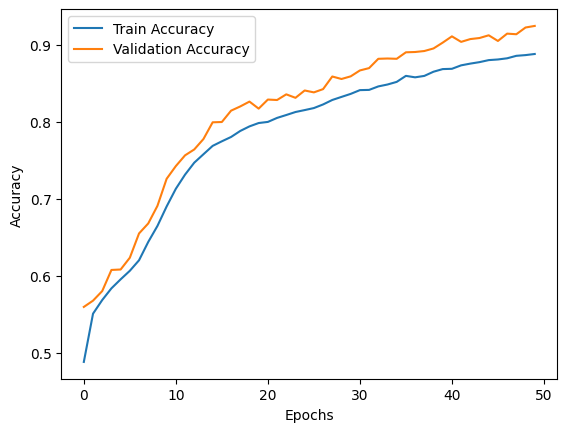

In [3]:
# Build LSTM Classifier
classifier = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Train LSTM Classifier (Before GAN Data)
history = classifier.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:
latent_dim = X.shape[2]  # Number of EEG features

# Generator Model
def build_generator():
    model = Sequential([
        Dense(64, activation='relu', input_dim=latent_dim),
        Dense(128, activation='relu'),
        Dense(X.shape[2], activation='tanh'),
        Reshape((1, X.shape[2]))  # Reshape to match LSTM input
    ])
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[2],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    return model

# Create Generator & Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Freeze discriminator while training GAN
discriminator.trainable = False

# Combined GAN Model
z = Input(shape=(latent_dim,))
gen_output = generator(z)
# Reshape the generator's output to match the discriminator's expected input shape
reshaped_gen_output = Reshape((latent_dim,))(gen_output)  # Reshape to (None, 5)
validity = discriminator(reshaped_gen_output)  # Pass reshaped output to discriminator
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.001))

print("Generator & Discriminator Models Created.")


Generator & Discriminator Models Created.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_samples = X_train[idx].reshape(batch_size, X.shape[2])  # Remove time dimension

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise).reshape(batch_size, X.shape[2])  # Generate fake data

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D Loss={d_loss[0]:.4f}, G Loss={g_loss:.4f}")

print("GAN Training Complete!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss=0.6910, G Loss=0.6891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [7]:
num_synthetic_samples = X_train.shape[0] // 2  # Generate 50% of real data size

# Generate synthetic EEG features
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Assign random labels to synthetic data
synthetic_labels = np.random.randint(0, 4, num_synthetic_samples)  # 4 emotion classes
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes=4)

# Print synthetic data example
print("Synthetic Data Example:\n", synthetic_data[:5])
print("Synthetic Labels Example:\n", synthetic_labels[:5])


637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Synthetic Data Example:
 [[[ 1.          1.          0.7934677  -1.          0.7823832 ]]

 [[ 0.99953014  0.9995262   0.8076878  -0.9995914   0.7915772 ]]

 [[ 0.9999995   0.9999995   0.77179384 -0.9999999   0.75985396]]

 [[ 0.9999817   0.9999715   0.78835493 -0.9999923   0.76829684]]

 [[ 1.          1.          0.7895008  -1.          0.77617145]]]
Synthetic Labels Example:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [9]:
# Merge real & synthetic data
X_combined = np.vstack((X_train, synthetic_data))  # Merge EEG features
Y_combined = np.vstack((Y_train, synthetic_labels))  # Merge emotion labels

# X_combined already has the correct shape for the LSTM: (samples, timesteps, features)
# NO NEED TO RESHAPE HERE. The shape is (61092, 1, 5) which is what the LSTM expects

print("Data after augmentation:", X_combined.shape, Y_combined.shape)

Data after augmentation: (61092, 1, 5) (61092, 4)


Epoch 1/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6658 - loss: 0.9469 - val_accuracy: 0.9154 - val_loss: 0.2222
Epoch 2/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6738 - loss: 0.6539 - val_accuracy: 0.9182 - val_loss: 0.2085
Epoch 3/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6700 - loss: 0.6569 - val_accuracy: 0.9220 - val_loss: 0.2074
Epoch 4/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6752 - loss: 0.6506 - val_accuracy: 0.9191 - val_loss: 0.2083
Epoch 5/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6735 - loss: 0.6521 - val_accuracy: 0.9255 - val_loss: 0.1970
Epoch 6/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6788 - loss: 0.6442 - val_accuracy: 0.9254 - val_loss: 0.2001
Epoch 7/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6793 - loss: 0.6425 - val_accuracy: 0.9278 - val_loss: 0.1895
Epoch 8/50
1910/1910 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6804 - loss: 0

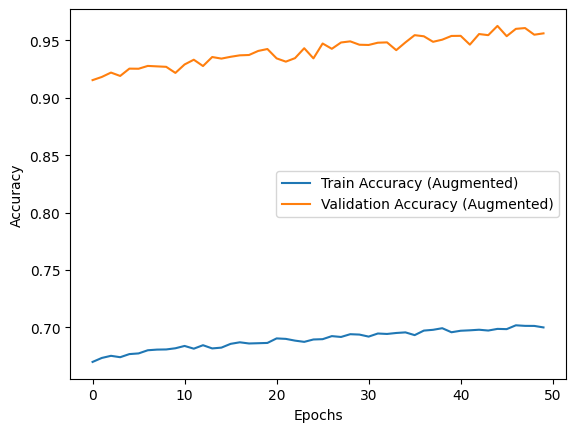

In [10]:
# Retrain LSTM with Augmented Data (Real + GAN)
history_aug = classifier.fit(X_combined, Y_combined, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Plot new accuracy
plt.plot(history_aug.history['accuracy'], label='Train Accuracy (Augmented)')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy (Augmented)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# Evaluate LSTM after GAN Augmentation
final_accuracy = classifier.evaluate(X_test, Y_test)[1]
print(f"Final LSTM Accuracy after GAN Augmentation: {final_accuracy * 100:.2f}%")


319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.1207
Final LSTM Accuracy after GAN Augmentation: 95.62%


In [12]:
# Save the trained LSTM model
classifier.save('/content/LSTM_GAN_Model.h5')
print("Model saved successfully!")


Model saved successfully!
